## Logistic Regression without PCA

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
df= pd.read_csv("titanic.csv").copy()

In [101]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [102]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [103]:
df.shape

(891, 12)

In [104]:
df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [105]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [106]:
# Dropping the null value rows from Embarked 
df.dropna(subset=['Embarked'], inplace=True)
df = df.drop(columns=['Name', 'Ticket'])

In [107]:
# Filling null values with median in Age column and mode in Cabin column
df['Age']=df['Age'].fillna(df['Age'].median())

# Extract deck from cabin (first letter)
df['Cabin'] = df['Cabin'].fillna("U")
df['Deck'] = df['Cabin'].str[0]
df = df.drop(columns=['Cabin'])


In [108]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Deck           0
dtype: int64

In [109]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
0,1,0,3,male,22.0,1,0,7.2500,S,U
1,2,1,1,female,38.0,1,0,71.2833,C,C
2,3,1,3,female,26.0,0,0,7.9250,S,U
3,4,1,1,female,35.0,1,0,53.1000,S,C
4,5,0,3,male,35.0,0,0,8.0500,S,U


In [110]:
cols = ['Deck','Sex','Embarked']
df = pd.get_dummies(df, columns=cols, drop_first=True)


In [111]:
corr_target = df.corr()['Survived'].sort_values(ascending=False)
print(corr_target)

Survived       1.000000
Fare           0.255290
Deck_B         0.166714
Deck_D         0.151555
Deck_E         0.146142
Deck_C         0.115629
Parch          0.083151
Deck_F         0.058388
Deck_G         0.016261
Embarked_Q     0.004536
PassengerId   -0.005028
Deck_T        -0.026409
SibSp         -0.034040
Age           -0.069822
Embarked_S    -0.151777
Deck_U        -0.313435
Pclass        -0.335549
Sex_male      -0.541585
Name: Survived, dtype: float64


In [112]:
# Train-test split (80-20 split)

X= df.drop('Survived', axis=1)
y= df['Survived']

m= X.shape[0]
train_size= int(0.8 * m)

indices = np.random.permutation(len(X))

train_idx = indices[:train_size]
test_idx = indices[train_size:]

X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

In [113]:
# Scaling the features (Standardisation)

mean= X_train.mean()
std = X_train.std()
std[std == 0] = 1  # prevent division by zero


X_train_sc= (X_train - mean) / std
X_test_sc= (X_test - mean) / std

In [114]:
# Sigmoid function

def sigmoid(z):
    z = np.clip(z, -500, 500)  # prevent overflow
    return 1 / (1 + np.exp(-z))


In [115]:
def log_loss(X, y, w, b):
    m = X.shape[0]
    epsilon = 1e-9  # small number to avoid log(0)
    cost = 0.0

    for i in range(m):
        z_i = np.dot(X[i], w) + b
        f_wb_i = sigmoid(z_i)

        # clip probabilities
        f_wb_i = np.clip(f_wb_i, epsilon, 1 - epsilon)

        cost += -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)

    return cost / m


In [116]:
# Compute gradient

def compute_gradient(X, y, w, b):
    m = X.shape[0]

    z = X @ w + b
    f = sigmoid(z)

    err = f - y

    dj_dw = (X.T @ err) / m
    dj_db = np.sum(err) / m

    return dj_db, dj_dw


In [117]:
# Compute gradient descent

def grad_des(X, y, w_in, b_in, alpha, num_iters):
    J_history = []
    w = w_in.copy()
    b = b_in

    for i in range(num_iters):
        dj_db, dj_dw = compute_gradient(X, y, w, b)

        w -= alpha * dj_dw
        b -= alpha * dj_db

        J_history.append(log_loss(X, y, w, b))

    return w, b, J_history

In [118]:
w_init = np.zeros(X_train.shape[1])
b_init = 0.0

X_train_np = X_train_sc.to_numpy()
y_train_np = y_train.to_numpy()

w, b, J_history = grad_des(X_train_np, y_train_np, w_init, b_init, 0.05, 1000)

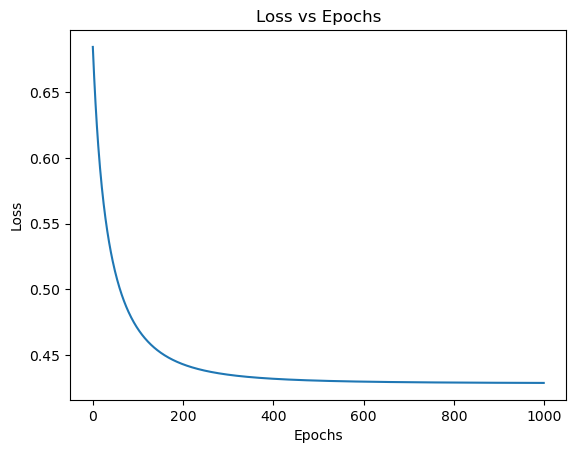

In [119]:
# Loss vs epochs plot

plt.figure()
plt.plot(J_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

In [120]:
X_test_np = X_test_sc.to_numpy()
y_test_np = y_test.to_numpy()


In [121]:
z = np.dot(X_test_np, w) + b
probs = sigmoid(z)
y_pred = (probs >= 0.5).astype(int)


In [125]:
TP = np.sum((y_pred == 1) & (y_test_np == 1))
TN = np.sum((y_pred == 0) & (y_test_np == 0))
FP = np.sum((y_pred == 1) & (y_test_np == 0))
FN = np.sum((y_pred == 0) & (y_test_np == 1))

print("TP:", TP)
print("TN:", TN)
print("FP:", FP)
print("FN:", FN)


TP: 47
TN: 95
FP: 14
FN: 22


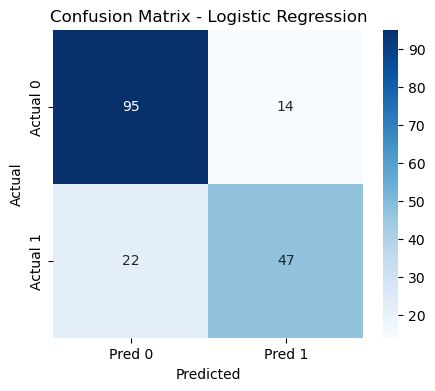

In [122]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_np, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [124]:
accuracy = np.sum(y_pred == y_test_np) / len(y_test_np)
print("Accuracy:", accuracy)


Accuracy: 0.797752808988764


In [126]:
precision = TP / (TP + FP)
print("Precision:", precision)


Precision: 0.7704918032786885


In [127]:
recall = TP / (TP + FN)
print("Recall:", recall)


Recall: 0.6811594202898551


In [128]:
f1 = 2 * (precision * recall) / (precision + recall)
print("F1 Score:", f1)


F1 Score: 0.7230769230769231


**Logistic Reg with PCA**

In [129]:
X_train= X_train_sc.to_numpy()
X_test= X_test_np

In [130]:
mean= np.mean(X_train, axis= 0)
X_train_centered= X_train - mean

In [131]:
# covariance matrix

cov_matrix = np.cov(X_train_centered, rowvar=False)


In [132]:
# Computing eigenvalues and eigenvectors

eig_val, eig_vec= np.linalg.eig(cov_matrix)

In [133]:

idx= np.argsort(eig_val)[::-1]
eig_val_sorted= eig_val[idx]
eig_vec_sorted= eig_vec[:, idx]

In [134]:
exp_var_ratio= eig_val_sorted / np.sum(eig_val_sorted)  # Explained variance ratio

print("Explained Variance Ratio:", exp_var_ratio)

Explained Variance Ratio: [0.17811826 0.10589102 0.09320385 0.06933194 0.06750354 0.06327059
 0.06144168 0.06004743 0.05871867 0.05109132 0.04679652 0.04148882
 0.03271025 0.0299534  0.02240555 0.01600057 0.00202657]


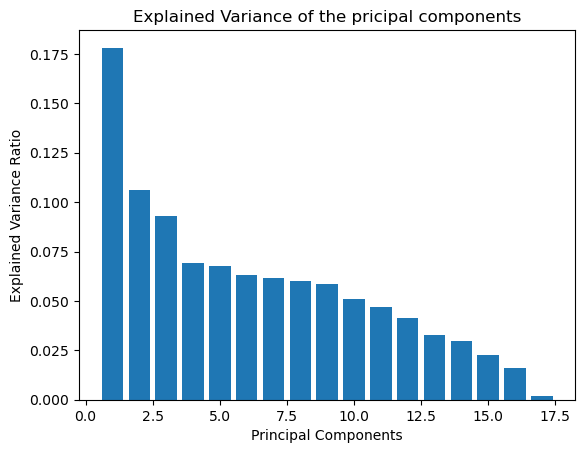

In [135]:

plt.figure()
plt.bar(range(1, len(exp_var_ratio) + 1),
        exp_var_ratio)

plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance of the pricipal components")
plt.show()


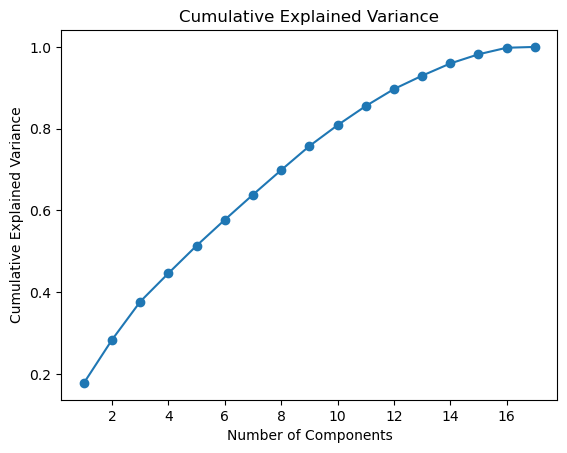

In [136]:
cum_var = np.cumsum(exp_var_ratio)

plt.figure()
plt.plot(range(1, len(cum_var) + 1), cum_var, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance")
plt.show()


Choosing k=7 because it gives a 90% varience, which is a good balance between compression and information.


In [137]:
k= np.argmax(cum_var >= 0.9) + 1  
# getting idx+1 of the first component whose cum var >=0.9, giving number of components chosen
print("No. of components chosen: ", k)

No. of components chosen:  13


In [138]:
W= eig_vec_sorted[:, :k]  # Projection matrix

In [139]:
# Projecting the data 

X_train_pca= np.dot(X_train_centered, W)

# Transforming the test data

X_test_centered= X_test - mean
X_test_pca= np.dot(X_test_centered, W)

In [ ]:
w_init = np.zeros(X_train_pca.shape[1])

w, b, J_history = grad_des(X_train_pca, y_train_np, w_init, b_init, 0.05, 1000)

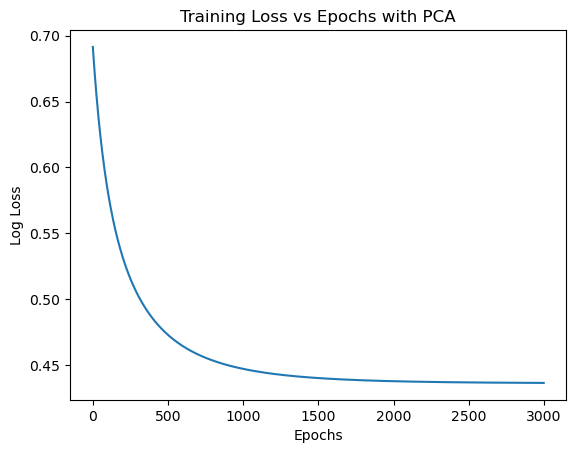

In [141]:
# Plotting loss vs epochs

plt.figure()
plt.plot(J_history)
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("Training Loss vs Epochs with PCA")
plt.show()

In [142]:
z = np.dot(X_test_pca, w) + b
probs = sigmoid(z)
y_pred = (probs >= 0.5).astype(int)

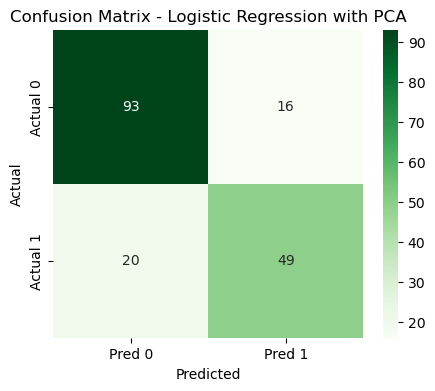

In [162]:
cm_pca = confusion_matrix(y_test_np, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm_pca,
            annot=True,
            fmt='d',
            cmap='Greens',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title("Confusion Matrix - Logistic Regression with PCA")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [143]:
accuracy = np.sum(y_pred == y_test_np) / len(y_test_np)
print("Accuracy - Logistic with PCA:", accuracy)

Accuracy - Logistic with PCA: 0.797752808988764


In [144]:
#confusion matrix and realted metrics
TP = np.sum((y_pred == 1) & (y_test_np == 1))
TN = np.sum((y_pred == 0) & (y_test_np == 0))
FP = np.sum((y_pred == 1) & (y_test_np == 0))
FN = np.sum((y_pred == 0) & (y_test_np == 1))

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.7538461538461538
Recall: 0.7101449275362319
F1 Score: 0.7313432835820897


Log Reg:

Without pca:   
**Precision: 0.7384615384615385   
Recall: 0.7619047619047619  
F1 Score: 0.75** 

With pca:  

**Precision: 0.7894736842105263  
Recall: 0.7142857142857143  
F1 Score: 0.7500000000000001** 

## <Precision has increased, recall decreased and F1 score remains the same.> 

# SVM without PCA

In [145]:
# converting 0 , 1 to -1, 1 

y_train_svm= np.where(y_train_np == 0, -1, 1)
y_test_svm= np.where(y_test_np == 0, -1, 1)

w= np.zeros(X_train_np.shape[1])
b= 0.0

In [146]:
def hinge_loss(X, y, w, b, lambda_cons, lr, iters):

    for _ in range(iters):
        for i, x_i in enumerate(X):

            condition= y[i] * (np.dot(x_i, w) + b) >= 1 

            if condition:
                w-= lr * (2 * lambda_cons * w)
            else:
                w -= lr * (2 * lambda_cons * w - y[i] * x_i)
                b -= lr * y[i]

    return w, b

In [165]:
w, b= hinge_loss(X_train_np, y_train_svm, w, b, 0.01, 0.01, 2000)

print("Trained weights:", w)
print("Trained bias:", b)

Trained weights: [ -0.04422212  -7.8684874   -2.10964095  -0.64179957   2.16849471
   6.0119917    3.30110359   2.5639217    3.59690133   3.9832722
   1.91870961  -0.10896769  -0.62159687  -7.18500747 -13.18530034
   0.90390225  -3.60668217]
Trained bias: 17599.060000116708


In [166]:
pred= np.dot(X_test_np, w) + b 
y_pred_svm= np.sign(pred) 

In [167]:
# -1 -> 0

y_pred_svm= np.where(y_pred_svm == -1, 0, 1)

In [168]:
TP = np.sum((y_pred_svm == 1) & (y_test_np == 1))
TN = np.sum((y_pred_svm == 0) & (y_test_np == 0))
FP = np.sum((y_pred_svm == 1) & (y_test_np == 0))
FN = np.sum((y_pred_svm == 0) & (y_test_np == 1))

print("TP:", TP)
print("TN:", TN)
print("FP:", FP)
print("FN:", FN)


TP: 69
TN: 0
FP: 109
FN: 0


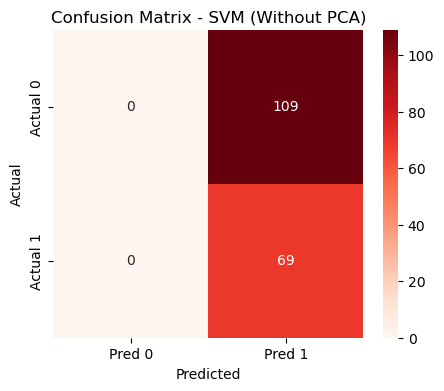

In [169]:

cm_svm = confusion_matrix(y_test_np, y_pred_svm)

plt.figure(figsize=(5,4))
sns.heatmap(cm_svm,
            annot=True,
            fmt='d',
            cmap='Reds',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title("Confusion Matrix - SVM (Without PCA)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [170]:
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print("F1 Score:", f1)

print("Precision:", precision)
print("Recall:", recall)


F1 Score: 0.5587044534412956
Precision: 0.38764044943820225
Recall: 1.0


## SVM with PCA

In [171]:


cov_matrix = np.cov(X_train_np, rowvar=False)


In [172]:
eig_val, eig_vec = np.linalg.eigh(cov_matrix)

idx = np.argsort(eig_val)[::-1]
eig_val_sorted = eig_val[idx]
eig_vec_sorted = eig_vec[:, idx]


In [173]:
exp_var_ratio = eig_val_sorted / np.sum(eig_val_sorted)
cumul_var = np.cumsum(exp_var_ratio)

k = np.argmax(cumul_var >= 0.9) + 1
print("Components chosen:", k)


Components chosen: 13


In [174]:
W = eig_vec_sorted[:, :k]

X_train_pca = np.dot(X_train_np, W)
X_test_pca = np.dot(X_test_np, W)


In [175]:
w_pca = np.zeros(X_train_pca.shape[1])
b_pca = 0.0

w_pca, b_pca = hinge_loss(
    X_train_pca,
    y_train_svm,
    w_pca,
    b_pca,
    0.01,
    0.01,
    2000
)


In [176]:
pred_pca = np.dot(X_test_pca, w_pca) + b_pca
y_pred_pca = np.sign(pred_pca)

y_pred_pca = np.where(y_pred_pca == -1, 0, 1)


In [177]:
TP_p = np.sum((y_pred_pca == 1) & (y_test_np == 1))
TN_p = np.sum((y_pred_pca == 0) & (y_test_np == 0))
FP_p = np.sum((y_pred_pca == 1) & (y_test_np == 0))
FN_p = np.sum((y_pred_pca == 0) & (y_test_np == 1))

precision_p = TP_p / (TP_p + FP_p) if (TP_p + FP_p) != 0 else 0
recall_p = TP_p / (TP_p + FN_p) if (TP_p + FN_p) != 0 else 0
f1_p = (2 * precision_p * recall_p) / (precision_p + recall_p) if (precision_p + recall_p) != 0 else 0


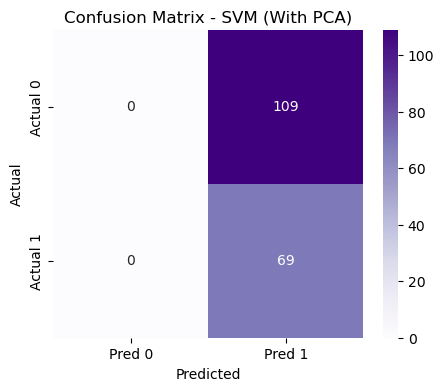

In [178]:
cm_svm_pca = confusion_matrix(y_test_np, y_pred_pca)

plt.figure(figsize=(5,4))
sns.heatmap(cm_svm_pca,
            annot=True,
            fmt='d',
            cmap='Purples',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title("Confusion Matrix - SVM (With PCA)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [179]:
print("\n=== Without PCA ===")
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

print("\n=== With PCA ===")
print("Precision:", precision_p)
print("Recall:", recall_p)
print("F1:", f1_p)



=== Without PCA ===
Precision: 0.38764044943820225
Recall: 1.0
F1: 0.5587044534412956

=== With PCA ===
Precision: 0.38764044943820225
Recall: 1.0
F1: 0.5587044534412956
